In [1]:
import keras
keras.__version__

'2.12.0'

In [2]:
import numpy as np
import argparse
import sys
import pandas as pd
import operator
import scipy as sc
from collections import defaultdict
from nltk import word_tokenize
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Concatenate, Reshape, Dropout, Conv2D, MaxPooling2D, ZeroPadding2D, Flatten, Input
from keras import backend as K
import h5py
import pickle

In [3]:
# import TensorFlow
import tensorflow as tf

#Check the version of TensorFlow you are using
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.12.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13456967478485216566
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 40146370560
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4505611242623243986
physical_device_desc: "device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:00:04.0, compute capability: 8.0"
xla_global_id: 416903419
]


In [4]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [5]:
in_colab = False
try:
    from google.colab import drive
    drive.mount('/content/drive')
    in_colab = True
except:
    pass

Mounted at /content/drive


In [6]:
def load():
    path = '/content/drive/My Drive/VQA/embeddings/embedding_matrix.h5'
    with h5py.File(path,'r') as hf:
        data = hf.get('embedding_matrix')
        embedding_matrix = np.array(data)
    return embedding_matrix

In [7]:
def load_idx():
    path = '/content/drive/My Drive/VQA/embeddings/word_idx'
    with open(path,'rb') as file:
        word_idx = pickle.load(file, encoding="latin1")
    return word_idx

In [8]:
def create(glove_path):
    embedding_matrix_path = '/content/drive/My Drive/VQA/embeddings/embedding_matrix.h5'
    word_idx_path = '/content/drive/My Drive/VQA/embeddings/word_idx'
    embeddings = {}
    word_idx = {}

    with open(glove_path,'r') as f:
        for i, line in enumerate(f):
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:],dtype='float32')
            embeddings[word] = coefs
            word_idx[word] = i+1

    num_words = len(word_idx)
    embedding_matrix = np.zeros((1+num_words,300))

    for i, word in enumerate(word_idx.keys()):
        embedding_matrix[i+1] = embeddings[word]

    with h5py.File(embedding_matrix_path, 'w') as hf:
        hf.create_dataset('embedding_matrix',data=embedding_matrix)

    with open(word_idx_path,'w') as f:
        pickle.dump(word_idx,f)

In [9]:
#parser = argparse.ArgumentParser()
#parser.add_argument('-address', type=str, required=True)
#args = parser.parse_args()
#print('Preparing embeddings ...')
#create(args.address)

In [10]:
def int_to_answers(data_path):
    df = pd.read_pickle(data_path)
    answers = df[['multiple_choice_answer']].values.tolist()
    freq = defaultdict(int)
    for answer in answers:
        freq[answer[0].lower()] += 1
    int_to_answer = sorted(freq.items(),key=operator.itemgetter(1),reverse=True)[0:1000]
    int_to_answer = [answer[0] for answer in int_to_answer]
    return int_to_answer

In [11]:
def answers_to_onehot(data_path):
    top_answers = int_to_answers(data_path)
    answer_to_onehot = {}
    for i, word in enumerate(top_answers):
        onehot = np.zeros(1001)
        onehot[i] = 1.0
        answer_to_onehot[word] = onehot
    return answer_to_onehot

In [12]:
def get_answers_matrix(data_path):
    df = pd.read_pickle(data_path)
    answers = df[['multiple_choice_answer']].values.tolist()
    answer_matrix = np.zeros((len(answers),1001))
    default_onehot = np.zeros(1001)
    default_onehot[1000] = 1.0

    for i, answer in enumerate(answers):
        answer_matrix[i] = answer_to_onehot_dict.get(answer[0].lower(),default_onehot)

    return answer_matrix

In [13]:
def get_questions_matrix(data_path):
    df = pd.read_pickle(data_path)
    questions = df[['question']].values.tolist()
    word_idx = load_idx()
    seq_list = []

    for question in questions:
        words = word_tokenize(question[0])
        seq = []
        for word in words:
            seq.append(word_idx.get(word,0))
        seq_list.append(seq)
    question_matrix = pad_sequences(seq_list)

    return question_matrix

In [14]:
def get_coco_features(data_path,id_map_path,features_path):
    img_labels = pd.read_pickle(data_path)[['image_id']].values.tolist()
    img_ids = open(id_map_path).read().splitlines()
    features_struct = sc.io.loadmat(features_path)

    id_map = {}
    for ids in img_ids:
        ids_split = ids.split()
        id_map[int(ids_split[0])] = int(ids_split[1])

    VGGfeatures = features_struct['feats']
    nb_dimensions = VGGfeatures.shape[0]
    nb_images = len(img_labels)
    image_matrix = np.zeros((nb_images,nb_dimensions))

    for i in range(nb_images):
        image_matrix[i,:] = VGGfeatures[:,id_map[img_labels[i][0]]]

    return image_matrix

In [15]:
train_data_path='/content/drive/My Drive/VQA/data/train_qa'
val_data_path='/content/drive/My Drive/VQA/data/val_qa'

id_map_path = '/content/drive/My Drive/VQA/coco_features/coco_vgg_IDMap.txt'
features_path = '/content/drive/My Drive/VQA/coco_features/vgg_feats.mat'
    
top_answers = int_to_answers(train_data_path)
answer_to_onehot_dict = answers_to_onehot(train_data_path)

#parser = argparse.ArgumentParser()
#parser.add_argument('-num_epochs', type=int, default=10)
#parser.add_argument('-batch_size', type=int, default=100)
#args = parser.parse_args()

print('Loading questions ...')
questions_train = get_questions_matrix(train_data_path)
questions_val = get_questions_matrix(val_data_path)
print('Loading answers ...')
answers_train = get_answers_matrix(train_data_path)
answers_val = get_answers_matrix(val_data_path)
print('Loading image features ...')
img_features_train = get_coco_features(train_data_path,id_map_path,features_path)
img_features_val = get_coco_features(val_data_path,id_map_path,features_path)

Loading questions ...
Loading answers ...
Loading image features ...


In [16]:
questions_val=questions_val[:,2:]

In [17]:
import tensorflow
tensorflow.keras.backend.set_image_data_format("channels_last")

In [30]:
img_features_train_s=img_features_train[:180000,:]
questions_train_s=questions_train[:180000,:]
answers_train_s=answers_train[:180000,:]

img_features_val_s=img_features_val[:100000,:]
questions_val_s=questions_val[:100000,:]
answers_val_s=answers_val[:100000,:]

del img_features_train
del questions_train
del answers_train

del img_features_val
del questions_val
del answers_val

In [31]:
#X_train = [img_features_train, questions_train, img_features_train]
#X_val = [img_features_val, questions_val, img_features_val]

X_train = [img_features_train_s, questions_train_s, img_features_train_s]
X_val = [img_features_val_s, questions_val_s, img_features_val_s]

In [32]:
from keras import Model
from keras.layers import Input

In [33]:
from keras.layers import concatenate

### Creating Model

In [ ]:
embedding_matrix=load()

In [ ]:
from keras import layers
embedding_matrix.shape

(2196017, 300)

In [ ]:
emb_input = keras.Input(shape=(4096,))
im1_input = keras.Input(shape=(25,))
im2_input = keras.Input(shape=(4096,))

emb = layers.Embedding(2196017, 300,
    weights = [embedding_matrix],
    trainable = False)(emb_input)

In [ ]:
emb = layers.Reshape((-1,300))(emb)

In [ ]:
im1 = layers.Dense(300,
            input_dim=4096,
            activation='linear')(im1_input)

im1 = layers.Reshape((1,300))(im1)

In [ ]:
im2 = layers.Dense(300,
            input_dim=4096,
            activation='linear')(im2_input)
im2 = layers.Reshape((1,300))(im2)

In [ ]:
concat = layers.concatenate([emb, im1, im2], axis=1)

In [ ]:
concat.shape

TensorShape([None, 4098, 300])

In [ ]:
keras.backend.set_image_data_format("channels_last")

In [ ]:
lstm = layers.LSTM(1001)(concat)

In [ ]:
output = Dropout(0.5)(lstm)
output = Dense(1001,activation='softmax')(output)

In [ ]:
model = keras.Model([emb_input, im1_input, im2_input], output)

In [ ]:
num_epochs=10
batch_size=100

model.compile(optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

In [ ]:
import tensorflow
tensorflow.config.run_functions_eagerly(True)

In [ ]:
from keras.callbacks import ModelCheckpoint
filepath = '/content/drive/MyDrive/VQA/weights/saved_model.h5'
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [ ]:
model.fit(X_train,answers_train_s,
    epochs=num_epochs,
    batch_size=batch_size,
    validation_data=(X_val,answers_val_s),
    callbacks=callbacks_list,
    verbose=1)

/usr/local/lib/python3.9/dist-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/10
1800/1800 [==============================] - ETA: 0s - loss: 3.8369 - accuracy: 0.2355
Epoch 1: loss improved from inf to 3.83688, saving model to /content/drive/MyDrive/VQA/weights/saved_model.h5
1800/1800 [==============================] - 1315s 727ms/step - loss: 3.8369 - accuracy: 0.2355 - val_loss: 3.6257 - val_accuracy: 0.2409
Epoch 2/10
1800/1800 [==============================] - ETA: 0s - loss: 3.7510 - accuracy: 0.2398
Epoch 2: loss improved from 3.83688 to 3.75096, saving model to /content/drive/MyDrive/VQA/weights/saved_model.h5
1800/1800 [==============================] - 1306s 725ms/step - loss: 3.7510 - accuracy: 0.2398 - val_loss: 3.6100 - val_accuracy: 0.2425
Epoch 3/10
1800/1800 [==============================] - ETA: 0s - loss: 3.7207 - accuracy: 0.2414
Epoch 3: loss improved from 3.75096 to 3.72071, saving model to /content/drive/MyDrive/VQA/weights/saved_model.h5
1800/1800 [==============================] - 1302s 723ms/step - loss: 3.7207 - accuracy: 0.2

In [ ]:
from keras.models import load_model

In [ ]:
model = load_model('/content/drive/MyDrive/VQA/weights/saved_model.h5')

In [ ]:
num_epochs=10
batch_size=100

In [ ]:
from keras.callbacks import ModelCheckpoint
filepath = '/content/drive/MyDrive/VQA/weights/saved_model2.h5'
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [ ]:
model.fit(X_train,answers_train_s,
    epochs=num_epochs,
    batch_size=batch_size,
    validation_data=(X_val,answers_val_s),
    callbacks=callbacks_list,
    verbose=1)

Epoch 1/10
1800/1800 [==============================] - ETA: 0s - loss: 3.6479 - accuracy: 0.2427
Epoch 1: loss improved from inf to 3.64794, saving model to /content/drive/MyDrive/VQA/weights/saved_model2.h5
1800/1800 [==============================] - 1204s 664ms/step - loss: 3.6479 - accuracy: 0.2427 - val_loss: 3.5249 - val_accuracy: 0.2444
Epoch 2/10
1800/1800 [==============================] - ETA: 0s - loss: 3.6312 - accuracy: 0.2433
Epoch 2: loss improved from 3.64794 to 3.63117, saving model to /content/drive/MyDrive/VQA/weights/saved_model2.h5
1800/1800 [==============================] - 1188s 660ms/step - loss: 3.6312 - accuracy: 0.2433 - val_loss: 3.5148 - val_accuracy: 0.2436
Epoch 3/10
1800/1800 [==============================] - ETA: 0s - loss: 3.6346 - accuracy: 0.2440
Epoch 3: loss did not improve from 3.63117
1800/1800 [==============================] - 1180s 655ms/step - loss: 3.6346 - accuracy: 0.2440 - val_loss: 3.5036 - val_accuracy: 0.2479
Epoch 4/10
1800/1800 [=

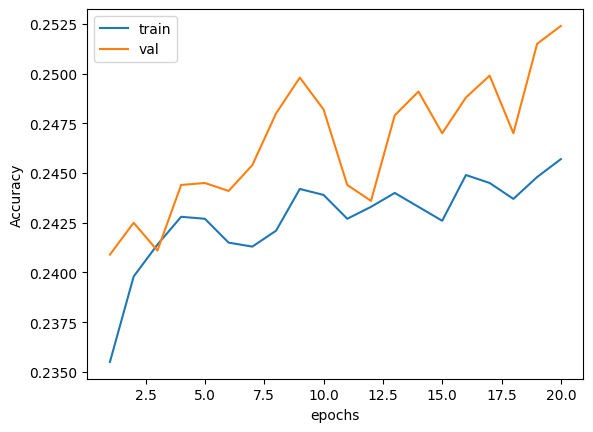

In [ ]:
#accuracy
from matplotlib import pyplot as plt
plt.plot([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20], [0.2355, 0.2398, 0.2414, 0.2428, 0.2427, 0.2415, 0.2413, 0.2421, 0.2442, 0.2439, 0.2427, 0.2433, 0.2440, 0.2433, 0.2426, 0.2449, 0.2445, 0.2437, 0.2448, 0.2457], label='train')
plt.plot([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20], [0.2409, 0.2425, 0.2411, 0.2444, 0.2445, 0.2441, 0.2454, 0.2480, 0.2498, 0.2482, 0.2444, 0.2436, 0.2479, 0.2491, 0.2470, 0.2488, 0.2499, 0.2470, 0.2515, 0.2524], label='val')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend()
#plt.show()

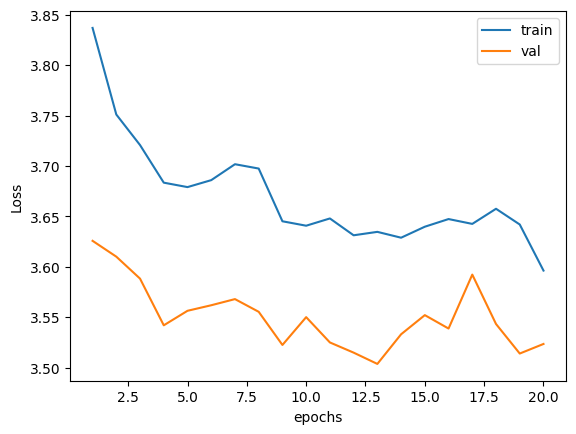

In [ ]:
plt.plot([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20], [3.8369, 3.7510, 3.7207, 3.6834, 3.6790, 3.6859, 3.7017, 3.6974, 3.6451, 3.6407, 3.6479, 3.6312, 3.6346, 3.6288, 3.6397, 3.6473, 3.6425, 3.6575, 3.6419, 3.5962], label='train')
plt.plot([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20], [3.6257, 3.6100, 3.5882, 3.5419, 3.5563, 3.5618, 3.5679, 3.5553, 3.5224, 3.5500, 3.5249, 3.5148, 3.5036, 3.5330, 3.5520, 3.5387, 3.5922, 3.5432, 3.5139, 3.5234], label='val')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend()
#plt.show()

In [ ]:
# old path = c:/Users/thari/Desktop/
model.save_weights('/content/drive/MyDrive/VQA/weights/model_weights.h5')
with open('/content/drive/MyDrive/VQA/weights/model_architecture.json', 'w') as f:
        f.write(model.to_json())

NameError: ignored

In [34]:
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.models import load_model
from keras.models import model_from_json

In [35]:
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten

In [36]:
#from keras.layers import Dense, Embedding, LSTM, Concatenate, Reshape, Dropout, Convolution2D, MaxPooling2D, ZeroPadding2D, Flatten, Input
#model = VGG_16('/content/drive/MyDrive/VQA/weights/vgg16_weights_th_dim_ordering_th_kernels.h5')
model=tensorflow.keras.applications.VGG16(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

553467096/553467096 [==============================] - 29s 0us/step


In [37]:
img_path='/content/drive/MyDrive/VQA/dog.jpeg'
img = tensorflow.keras.utils.load_img(img_path,target_size=(224,224))

In [38]:
#model = VGG_16('weights/vgg16_weights_th_dim_ordering_th_kernels.h5')
#img_path='/content/drive/MyDrive/VQA/dog.jpeg'
#img = image.load_img(img_path,target_size=(224,224))
x = tensorflow.keras.utils.img_to_array(img)
x = np.expand_dims(x,axis=0)
x = preprocess_input(x)
#last_layer_output = K.function([model.layers[0].input,K.learning_phase()],[model.layers[-1].input])
#features = last_layer_output([x,0])[0]

In [39]:
last_layer_output=model.get_layer('fc2').output

In [40]:
last_layer_output

<KerasTensor: shape=(None, 4096) dtype=float32 (created by layer 'fc2')>

In [41]:
from tensorflow.keras.models import Model

In [42]:
submodel = Model(model.inputs, model.get_layer("fc2").output)   
results = submodel.predict(x)

1/1 [==============================] - 7s 7s/step


In [43]:
features = results

In [ ]:
def extract_image_features(img_path):
	model = VGG_16('weights/vgg16_weights_th_dim_ordering_th_kernels.h5')
	img = image.load_img(img_path,target_size=(224,224))
	x = image.img_to_array(img)
	x = np.expand_dims(x,axis=0)
	x = preprocess_input(x)
	last_layer_output = K.function([model.layers[0].input,K.learning_phase()],
		[model.layers[-1].input])
	features = last_layer_output([x,0])[0]
	return features


In [44]:
def preprocess_question(question):
	word_idx = load_idx()
	tokens = word_tokenize(question)
	seq = []
	for token in tokens:
		seq.append(word_idx.get(token,0))
	seq = np.reshape(seq,(1,len(seq)))
	return seq

In [48]:
seq = preprocess_question('Which animal is this?')
seq=tf.keras.utils.pad_sequences(
    seq,
    maxlen=25,
    dtype='int32',
    padding='pre',
    truncating='pre',
    value=0
)

In [49]:
x = [features, seq, features]

In [50]:
with open('/content/drive/MyDrive/VQA/weights/model_architecture.json', 'r') as f:
    		model = model_from_json(f.read())
model.load_weights('/content/drive/MyDrive/VQA/weights/saved_model.h5')

In [51]:
features=tensorflow.reshape(features, [1,-1,4096])

In [52]:
probabilities = model.predict(x)[0]

1/1 [==============================] - 1s 1s/step


In [53]:
probabilities

array([2.1996883e-01, 1.5637998e-01, 4.7545880e-02, ..., 4.8881695e-08,
       7.7467791e-07, 1.6433164e-01], dtype=float32)

In [54]:
predictions = np.argsort(probabilities[:1000])

In [58]:
df = pd.read_pickle(val_data_path)
answers = df[['multiple_choice_answer']].values.tolist()
freq = defaultdict(int)
for answer in answers:
  freq[answer[0].lower()] += 1
int_to_answer = sorted(freq.items(),key=operator.itemgetter(1),reverse=True)[0:1000]
int_to_answer = [answer[0] for answer in int_to_answer]

In [81]:
top_answers=int_to_answer

In [ ]:
top_answers = [top_answers[predictions[-1]],
top_answers[predictions[-2]],
top_answers[predictions[-3]]]


In [82]:
print('Top answers: %s, %s, %s.' % (top_answers[0],top_answers[1],top_answers[2]))

Top answers: dog, lion, cat.
